In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

In [2]:
# DAG
dag = [
     {'depends': [], 'duration': 4},
     {'depends': [0], 'duration': 4},
     {'depends': [0], 'duration': 2},
     {'depends': [1], 'duration': 5},
     {'depends': [1], 'duration': 2},
     {'depends': [2], 'duration': 3},
     {'depends': [2], 'duration': 2},
     {'depends': [2], 'duration': 3},
     {'depends': [4, 5, 6], 'duration': 2},
     {'depends': [3, 7, 8], 'duration': 2},
]

for i, task in enumerate(dag):
    print("Task {}: duration: {}, depends on {}".format(i+1, task['duration'], [x+1 for x in task['depends']]))

Task 1: duration: 4, depends on []
Task 2: duration: 4, depends on [1]
Task 3: duration: 2, depends on [1]
Task 4: duration: 5, depends on [2]
Task 5: duration: 2, depends on [2]
Task 6: duration: 3, depends on [3]
Task 7: duration: 2, depends on [3]
Task 8: duration: 3, depends on [3]
Task 9: duration: 2, depends on [5, 6, 7]
Task 10: duration: 2, depends on [4, 8, 9]


In [3]:
def simulate(n, dag):
    samples = []
    for task in dag:
        samples.append(np.random.exponential(task['duration'], n))
   
    times = np.zeros((len(dag), n))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i, :] = np.max(times[task['depends'], :] + samples[i], axis=0)
        else:
            times[i, :] = samples[i]
            
    df = pd.DataFrame(times).transpose()
    df.columns = ['task_' + str(x+1) for x in df.columns]
    return df
        
simulate(3, dag)

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,16.856666,17.409344,25.631734,28.458600,18.301231,29.574868,31.469426,27.554293,36.446184,36.604749
1,0.137174,1.393538,1.480947,4.687014,2.147992,2.874156,4.325578,1.547606,5.728324,7.072494
2,7.768523,7.799160,9.600391,9.210625,8.082927,10.532700,11.708784,14.630925,12.174325,15.673844


,N,count,ratio
0,1000,0,0.000000
1,10000,0,0.000000
2,50000,1,0.000020
3,100000,5,0.000050
4,500000,14,0.000028
5,1000000,25,0.000025
6,5000000,150,0.000030


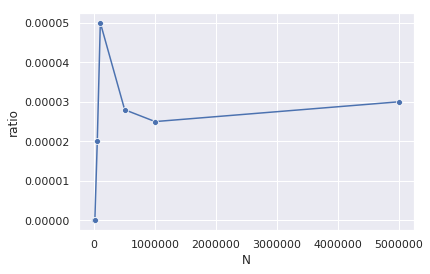

In [4]:
# Number of times we go over 70 day time limit at different time limits
trials = []
for N in [1000, 10000, 50000, 100000, 500000, 1000000, 5000000]:
    df = simulate(N, dag)
    count = len(df[df.task_10 > 70])
    trials.append({'N': N, 'count': count, 'ratio': count / len(df)})
                  
trials = pd.DataFrame(trials)
display(trials)
sns.lineplot(x='N', y='ratio', data=trials, markers=True, marker='o')

In [5]:
def simulate_importance(n, dag, importance_parameters=None):
    ''' Compute E(T_10 >= 70) = 1/n \sum I(T_10 > 70) \pi_k likelihood_ratio_k '''
    if importance_parameters is None:
        importance_parameters = [1.] * (len(dag))
    assert len(dag) == len(importance_parameters)
   
    # Sample from the importance distribution to get all our task times
    q_samples = []
    durations = []
    for i, task in enumerate(dag):
        durations.append(task['duration'])
        q_sample = np.random.exponential(importance_parameters[i], n)
        q_samples.append(q_sample)
            
    # Compute the likelihood ratios in log space [exp(-T/\theta) /\theta] / [exp(-T/\lambda) / \lambda]
    stacked_q_samples = np.stack(q_samples, axis=1)
    log_durations = np.log(durations)
    log_importance_parameters = np.log(importance_parameters)
    likelihoods = np.sum((-log_durations - stacked_q_samples / durations) - 
                         (-log_importance_parameters - stacked_q_samples / importance_parameters),
                         axis=1)
                  
    # Compute final outcome variable
    times = np.zeros((len(dag), n))
    for i, task in enumerate(dag):
        if task['depends']:
            times[i, :] = np.max(times[task['depends'], :] + q_samples[i], axis=0)
        else:
            times[i, :] = q_samples[i]
                
    outcome = np.where(times[-1, :] >= 70, 1., 0.) * np.exp(likelihoods)
    return np.mean(outcome)

#params = [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]
params = [16, 16, 2, 20, 2, 3, 2, 3, 2, 16]
simulate_importance(10000, dag, params)

3.095510897195079e-05

In [6]:
distributions = [
    ('original', [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]), # original
    ('4x_all', [4 * x for x in [4, 4, 2, 5, 2, 3, 2, 3, 2, 2]]), # quadrupling
    ('2x_critical', [8, 8, 2, 10, 2, 3, 2, 3, 2, 4]), # 2x Multiplicative change in bottleneck tasks 1, 2, 4, 10
    ('3x_critical', [12, 12, 2, 15, 2, 3, 2, 3, 2, 12]), # 3x Multiplicative change in bottleneck tasks 1, 2, 4, 10
    ('4x_critical', [16, 16, 2, 20, 2, 3, 2, 3, 2, 16]), # 4x Multiplicative change in bottleneck tasks 1, 2, 4, 10
]

data = []
for name, importance_params in distributions:
    for N in [1000, 10000, 50000, 100000, 500000, 1000000]:
        mean = simulate_importance(100000, dag, importance_params)
        data.append((name, N, mean))
df_importance = pd.DataFrame(data, columns=['experiment', 'sample_size', 'mean'])        
df_importance

,experiment,sample_size,mean
0,original,1000,0.000020
1,original,10000,0.000030
2,original,50000,0.000020
3,original,100000,0.000010
4,original,500000,0.000040
5,original,1000000,0.000030
6,4x_all,1000,0.000028
7,4x_all,10000,0.000030
8,4x_all,50000,0.000031
9,4x_all,100000,0.000026


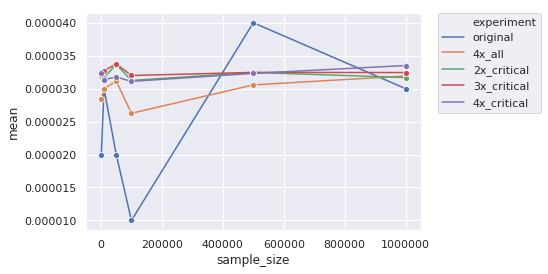

In [7]:
sns.lineplot(x='sample_size', y='mean', hue='experiment', data=df_importance, markers=True, marker='o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)